### **Student Information**
Name: Pablo Nicolas Maldonado Lesme

Student ID: M11352803

GitHub ID: nicomaldox

Kaggle name: nicomaldox

Kaggle private scoreboard snapshot: 



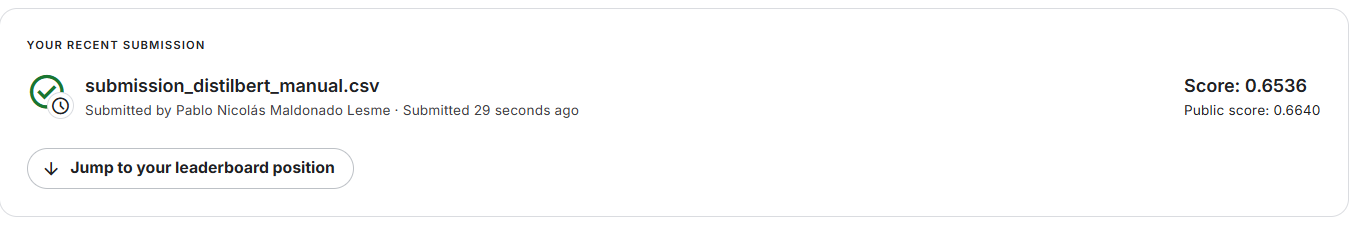

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import dotenv
import gensim
import tensorflow
import tensorflow_hub
import keras
from bs4 import BeautifulSoup
import gradio
import jupyter
import sklearn
import pandas
import numpy
import matplotlib
import plotly
import seaborn
import nltk
import umap
import scipy
import torch
import json
%matplotlib inline
print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

In [ ]:
# %pip install transformers evaluate datasets accelerate huggingface_hub --upgrade

In [ ]:
import torch
import transformers
import evaluate
print("Torch version:", torch.__version__)
print("Transformers version:", transformers.__version__)

In [ ]:
import pandas as pd

In [ ]:
df_id = pd.read_csv("/kaggle/input/dm-lab-2-private-competition/data_identification.csv")
df_emotion = pd.read_csv("/kaggle/input/dm-lab-2-private-competition/emotion.csv")

print("df_id", list(df_id.columns))
print("df_emotion", list(df_emotion.columns))

In [ ]:
with open("/kaggle/input/dm-lab-2-private-competition/final_posts.json", "r", encoding="utf-8") as f:
    posts = json.load(f)
df_posts = pd.json_normalize(posts, sep="_")

In [ ]:
# Better json file reading
df_posts = pd.json_normalize(posts, sep="_")

# Extract id and text
df_posts = df_posts.rename(columns={
    "root__source_post_post_id": "id",
    "root__source_post_text": "text"
})[["id", "text"]]

# Clean columns
df_id.columns = df_id.columns.str.strip().str.lower()
df_emotion.columns = df_emotion.columns.str.strip().str.lower()
df_posts.columns = df_posts.columns.str.strip().str.lower()

# Merge
df = pd.merge(df_id, df_posts, on="id", how="left")
df = pd.merge(df, df_emotion, on="id", how="left")

# Split into train and test
train_df = df[df["split"] == "train"].dropna(subset=["emotion"])
test_df = df[df["split"] == "test"]

# Save
train_df.to_csv("train_ready.csv", index=False)
test_df.to_csv("test_ready.csv", index=False)

print("Train:\n",train_df.head(5))
print("Test:\n",test_df.head(5))


In [ ]:
import re
import pandas as pd
import emoji
# read the new data
train_df = pd.read_csv("train_ready.csv")
test_df  = pd.read_csv("test_ready.csv")

def clean_text(t: str) -> str:
    t = str(t).lower()
    t = emoji.replace_emoji(t, replace='')           
    t = re.sub(r"http\S+|www\S+", " ", t)           
    t = re.sub(r"@\w+", " ", t)                    
    t = re.sub(r"#(\w+)", r"\1", t)                 
    t = re.sub(r"[^a-z0-9'!?.,\s]", " ", t)         
    t = re.sub(r"\s+", " ", t).strip()
    return t

train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"]  = test_df["text"].apply(clean_text)

train_df.head(5)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def advanced_clean(text):
    text = clean_text(text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(words)

train_df["clean_text"] = train_df["text"].apply(advanced_clean)
test_df["clean_text"]  = test_df["text"].apply(advanced_clean)

In [ ]:
train_df.to_csv("train_cleaned.csv", index=False)
test_df.to_csv("test_cleaned.csv", index=False)
test_df.head(5)

In [ ]:
import matplotlib.pyplot as plt

# 1. Efficient Data Calculation
# value_counts(normalize=True) calculates percentages automatically
df1 = train_df['emotion'].value_counts(normalize=True) * 100

# 2. Setup Plot
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Create Bars (zorder=3 puts bars in front of grid)
bars = ax.bar(df1.index, df1.values, color='#4c72b0', width=0.6, zorder=3)

# 4. Styling & Clean up
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)  # Grid behind bars
ax.set_title('Emotion Distribution', fontsize=16, pad=15)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.tick_params(axis='x', rotation=0, labelsize=11) # Rotation 0 often easier if labels fit

# Remove top and right borders (Modern look)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) # Optional: Remove left line, keep ticks

# 5. Add Value Labels
# Increase y-limit slightly so text fits
ax.set_ylim(0, df1.max() * 1.15) 

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1, # Slight offset
        f"{height:.1f}%", # F-string rounding
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='#333333'
    )

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [ ]:
# BOW
BOW_vectorizer = CountVectorizer() 

# Learn from the tokens
BOW_vectorizer.fit(train_df['text'])

# 2. Transform to term matrix train and text
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [ ]:
#TF-IDF
TFIDF_1000 = TfidfVectorizer(
    max_features=1000, tokenizer=nltk.word_tokenize, lowercase=True, stop_words='english'            
)

# Tokenize text
TFIDF_1000.fit(train_df['text'])
train_data_TFIDF_features = TFIDF_1000.transform(train_df['text'])

# names
f_n_1000 = TFIDF_1000.get_feature_names_out()
print(f_n_1000[400:410])

In [ ]:
# Building a small set
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

In [ ]:
f_n_500 = BOW_500.get_feature_names_out()
f_n_500[400:410]

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
from sklearn.model_selection import train_test_split
# Train and test
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']


X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2,        
    random_state=42, 
    stratify=y_train      
)

print("X_train_sub:", X_train_sub.shape)
print("y_train_sub:", y_train_sub.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

In [ ]:
#Naive Bayes
NB_model = MultinomialNB()
NB_model.fit(X_train_sub, y_train_sub)

y_pred_train = NB_model.predict(X_train_sub)
y_val_test = NB_model.predict(X_val)

acc_train = accuracy_score(y_train_sub, y_pred_train)
acc_val= accuracy_score(y_val, y_val_test)

print(f"Training accuracy: {acc_train:.2f}")
print(f"Testing accuracy : {acc_val:.2f}")


In [ ]:
import evaluate
print("Evaluate version:", evaluate.__version__)

In [ ]:
# destilRoberta
import os, random, math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
import evaluate
from tqdm.auto import tqdm

SEED = 42

BATCH_SIZE = 32
NUM_EPOCHS = 8
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06
MAX_LEN = 64

USE_RDROP = True
RDROP_ALPHA = 0.5

USE_FOCAL = False
FOCAL_GAMMA = 2.0

USE_MIXOUT = False
MIXOUT_P = 0.1

EARLY_STOPPING_PATIENCE = 2


MODEL_NAME = "distilroberta-base"

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device =", device)


# Load data

train_df = pd.read_csv("train_ready.csv")
test_df  = pd.read_csv("test_ready.csv")

train_df = train_df.dropna(subset=["text","emotion"]).reset_index(drop=True)
test_df = test_df.fillna({"text": ""}).reset_index(drop=True)

le = LabelEncoder().fit(train_df["emotion"])
train_df["label"] = le.transform(train_df["emotion"])

id2label = {i:c for i,c in enumerate(le.classes_)}
label2id = {c:i for i,c in enumerate(le.classes_)}
num_labels = len(le.classes_)

tr_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=SEED,
    stratify=train_df["label"]
)

class_weights_np = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_labels),
    y=tr_df["label"]
)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32, device=device)
print("Class weights:", class_weights_np)

#tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class EmotionDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.texts = df["text"].tolist()
        self.is_train = is_train
        if is_train:
            self.labels = df["label"].tolist()
        else:
            self.labels = None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

        if self.labels is not None:
            item["label"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item


train_dataset = EmotionDataset(tr_df, is_train=True)
val_dataset   = EmotionDataset(val_df, is_train=True)
test_dataset  = EmotionDataset(test_df, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



#Mixout

class MixLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, target_weight=None, p=0.0):
        super().__init__(in_features, out_features, bias=bias)
        self.p = p
        if target_weight is None:
            target_weight = self.weight.data.clone()
        self.register_buffer("target_weight", target_weight.clone())

    def forward(self, input):
        if self.training and self.p > 0:
            mask = torch.bernoulli((1 - self.p) * torch.ones_like(self.weight))
            weight = self.weight * mask + self.target_weight * (1 - mask)
        else:
            weight = self.weight
        return nn.functional.linear(input, weight, self.bias)


def apply_mixout_to_model(model, p):
    if p <= 0:
        return model

    for name, module in model.named_children():
        apply_mixout_to_model(module, p)
        if isinstance(module, nn.Linear):
            mix = MixLinear(
                module.in_features,
                module.out_features,
                bias=module.bias is not None,
                target_weight=module.weight.data.clone(),
                p=p
            )
            if module.bias is not None:
                mix.bias.data = module.bias.data.clone()
            setattr(model, name, mix)
    return model



#Model

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

if USE_MIXOUT:
    model = apply_mixout_to_model(model, MIXOUT_P)

model = model.to(device)


#Optimizer/Scheduler

no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [
    {
        "params":[p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY
    },
    {
        "params":[p for n,p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
    }
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

num_training_steps = NUM_EPOCHS * len(train_loader)
num_warmup_steps = int(WARMUP_RATIO * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


#Metrics

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def eval_on_loader(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    out = {}
    out.update(metric_acc.compute(predictions=all_preds, references=all_labels))
    out.update(metric_f1.compute(predictions=all_preds, references=all_labels, average="macro"))
    return out



#Loss functions

def compute_weighted_smoothed_ce(logits, labels):
    eps = 0.05
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    n_classes = log_probs.size(-1)

    with torch.no_grad():
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(eps / (n_classes - 1))
        true_dist.scatter_(1, labels.unsqueeze(1), 1 - eps)

    weighted_log_probs = true_dist * log_probs * class_weights.unsqueeze(0)
    return -weighted_log_probs.sum(dim=1).mean()


def compute_focal_factor(logits, labels, gamma=2.0):
    probs = torch.softmax(logits, dim=-1)
    pt = probs.gather(1, labels.unsqueeze(1)).squeeze(1)
    return (1 - pt).clamp(min=1e-6) ** gamma


def compute_rdrop_kl(logits1, logits2):
    log_p1 = torch.nn.functional.log_softmax(logits1, dim=-1)
    log_p2 = torch.nn.functional.log_softmax(logits2, dim=-1)
    p1 = log_p1.exp()
    p2 = log_p2.exp()

    kl1 = torch.nn.functional.kl_div(log_p1, p2, reduction="batchmean")
    kl2 = torch.nn.functional.kl_div(log_p2, p1, reduction="batchmean")
    return 0.5 * (kl1 + kl2)



#Training Loop

best_f1 = -1.0
best_state = None
patience = 0

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")

    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs1 = model(input_ids=input_ids, attention_mask=attention_mask)
        logits1 = outputs1.logits

        base_loss = compute_weighted_smoothed_ce(logits1, labels)

        loss = base_loss

        if USE_RDROP:
            outputs2 = model(input_ids=input_ids, attention_mask=attention_mask)
            logits2 = outputs2.logits

            base_loss2 = compute_weighted_smoothed_ce(logits2, labels)
            kl = compute_rdrop_kl(logits1, logits2)

            loss = 0.5 * (base_loss + base_loss2) + RDROP_ALPHA * kl

        if USE_FOCAL:
            focal = compute_focal_factor(logits1, labels, gamma=FOCAL_GAMMA)
            loss = loss * focal.mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    
    val_metrics = eval_on_loader(model, val_loader)
    print(f"\nEpoch {epoch}: val_acc={val_metrics['accuracy']:.4f}, val_f1={val_metrics['f1']:.4f}")

    if val_metrics["f1"] > best_f1 + 1e-4:
        best_f1 = val_metrics["f1"]
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        patience = 0
        print("New best model saved!")
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("⏹ Early stopping")
            break


#Load/Evaluate

model.load_state_dict(best_state)
print("Final Validation:", eval_on_loader(model, val_loader))


#Prediction

model.eval()
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=-1)
        all_preds.extend(preds.cpu().numpy())

labels = le.inverse_transform(all_preds)

sub = pd.DataFrame({"id": test_df["id"], "emotion": labels})
sub.to_csv("submission_distilbert_manual.csv", index=False, encoding="utf-8-sig")
print("Saved: submission_roberta_base_manual.csv")